In [63]:
import shutil
import ultralytics
from pathlib import Path
import yaml
import random
import ultralytics
from ultralytics import YOLO
import os
import numpy as np

import cv2
from ultralytics.models.sam import SAM3SemanticPredictor
from ultralytics.models.sam import SAM3Predictor

In [1]:
!pip install ultralytics
!pip install "numpy<1.24.4"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 19.6 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 107.0 MB/s eta 0:00:0000:010:01
  Installing build dependencies ... done
  error: subprocess-exited-with-error
  
  × Getting requirements to build wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Getting requirements to build wheel ... error
error: subprocess-exited-with-error

× Getting requirements to build wheel did not run successfully.
│ exit code: 1
╰─> See above for output.

note: This error originates from a subprocess, and is likely not a problem with pip.


In [2]:
!nvidia-smi

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Sun Jan 25 14:55:39 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 570.172.08             Driver Version: 570.172.08     CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla 

In [8]:
inputPath = '/kaggle/input/warp-waste-recycling-plant-dataset/Warp-D'
workingPath = "/kaggle/working/waste_dataSet/Warp-D"

shutil.copytree(inputPath, workingPath, dirs_exist_ok=True)

'/kaggle/working/waste_dataSet/Warp-D'

In [9]:
workingPath = "/kaggle/working/waste_dataSet/Warp-D"

with open( Path(workingPath).joinpath('classes.txt'), 'r') as f:
    classNames = [line.strip() for line in f.readlines()]
print(len(classNames))

trainPath = Path(workingPath).joinpath('train/images')
trainAllFiles = [str(file) for file in trainPath.glob('*') if str(file).endswith(('.jpg', '.png'))]
random.shuffle(trainAllFiles)

trainTestSplit = 0.8
partitionPoint = int(trainTestSplit * len(trainAllFiles))
trainFiles = trainAllFiles[:partitionPoint]
validationFiles = trainAllFiles[partitionPoint:]

trainFile = Path(workingPath).joinpath('train.txt')
valFile = Path(workingPath).joinpath('val.txt')
with open(trainFile, "w") as train_file:
    train_file.write("\n".join(trainFiles))
with open(valFile, "w") as val_file:
    val_file.write("\n".join(validationFiles))

data = {
    'train': str(trainFile),
    'val': str(valFile),
    'test' : str(Path(workingPath).joinpath('test/images')),
    'nc': len(classNames),
    'names': classNames
}

# yaml файл
yaml_output_path = Path(workingPath).joinpath('data.yaml')
with open(yaml_output_path, "w") as f:
    yaml.dump(data, f, default_flow_style=False)

28


## Обучение модели

In [ ]:
ultralytics.checks()

!yolo train model=/kaggle/input/samyolo/yolo12s.pt data=/kaggle/working/waste_dataSet/Warp-D/data.yaml epochs=200 freeze=5 imgsz=640 batch=16 save_period=5

## Детекция Yolo


image 1/1 /kaggle/working/waste_dataSet/Warp-D/test/images/POSAD_1_12-Sep_20-15-33.jpg: 384x640 2 bottle-blues, 2 bottle-darks, 1 bottle-milk, 1 bottle-transp, 1 bottle-oil, 1 bottle-green-full, 2 bottle-blue5ls, 17.3ms
Speed: 2.8ms preprocess, 17.3ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)
[[493.171630859375, 419.3117980957031, 681.6763305664062, 520.537841796875], [264.0319519042969, 206.7506103515625, 449.7074890136719, 302.4959716796875], [320.0926513671875, 298.7161560058594, 467.0843505859375, 391.0506591796875], [457.4988098144531, 143.93389892578125, 676.515625, 279.23077392578125], [202.31117248535156, 371.22869873046875, 370.91680908203125, 539.4593505859375], [293.59442138671875, 116.1492691040039, 378.38690185546875, 219.91104125976562], [457.63629150390625, 145.25222778320312, 676.6239013671875, 276.6776123046875], [251.59144592285156, 346.73382568359375, 353.927001953125, 436.3927001953125], [468.9738464355469, 1.0287094116210938, 553.67639160156

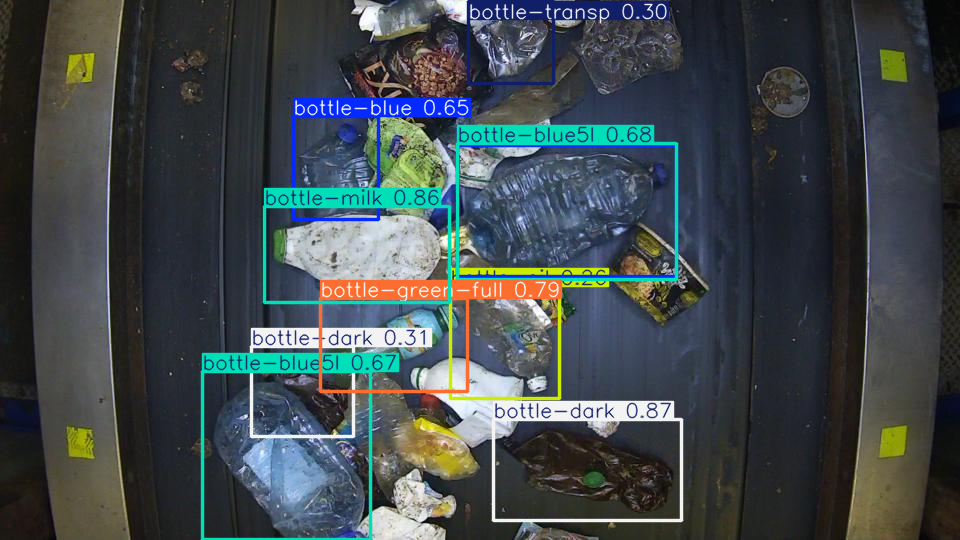

In [60]:
model = YOLO("/kaggle/input/samyolo/yolo11s_rubbish.pt")  # модель после обучения

train_cellpose = np.array(os.listdir('/kaggle/working/waste_dataSet/Warp-D/test/images/'), dtype = object)

for i in train_cellpose[20:21]:
    results = model(f"/kaggle/working/waste_dataSet/Warp-D/test/images/{i}")  # predict on an image
    #/kaggle/input/warp-waste-recycling-plant-dataset/Warp-D/test/images/Monitoring_photo2_04-Mar_00-47-42.jpg
    for result in results:
        # xywh = result.boxes.xywh  # center-x, center-y, width, height
        # xywhn = result.boxes.xywhn  # normalized
        # xyxy = result.boxes.xyxy  # top-left-x, top-left-y, bottom-right-x, bottom-right-y
        # xyxyn = result.boxes.xyxyn  # normalized
        # names = [result.names[cls.item()] for cls in result.boxes.cls.int()]  # class name of each box
        # confs = result.boxes.conf  # confidence score of each box

        boxes=result.boxes.xyxy.tolist()

        print(boxes)
    
        result.show()

## Семантическая сегментация

Ultralytics 8.4.7 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
WARNING ⚠️ imgsz=[640] must be multiple of max stride 14, updating to [644]

image 1/1 /kaggle/working/waste_dataSet/Warp-D/test/images/POSAD_1_12-Sep_20-15-33.jpg: 644x644 40 visuals, 111.5ms
Speed: 2.6ms preprocess, 111.5ms inference, 1.6ms postprocess per image at shape (1, 3, 644, 644)
Results saved to /kaggle/working/runs/segment/predict10


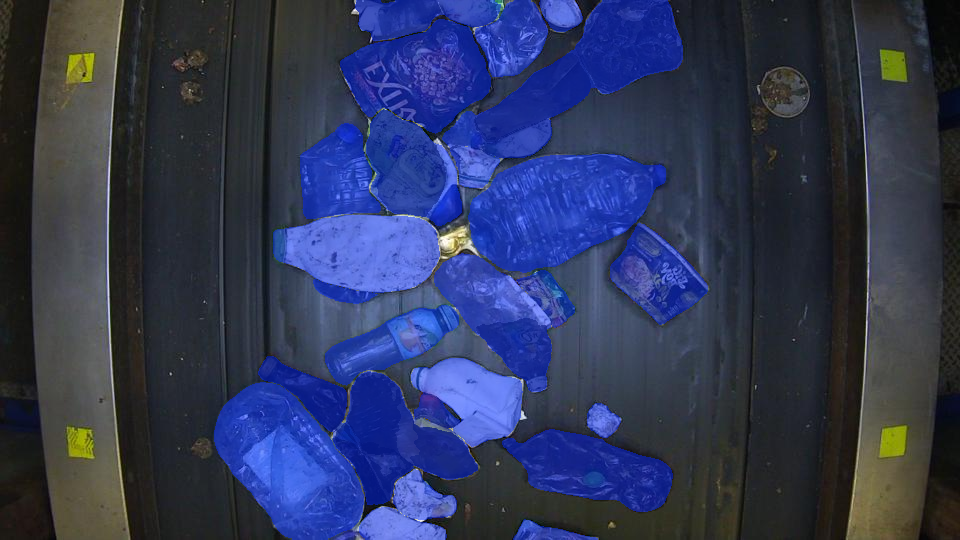

In [61]:
overrides = dict(conf=0.25, task="segment", mode="predict", model="/kaggle/input/samyolo/SAM.pt", half=True, save=True)
predictor = SAM3SemanticPredictor(overrides=overrides)

predictor.set_image(f"/kaggle/working/waste_dataSet/Warp-D/test/images/{train_cellpose[20:21][0]}")

results = predictor(bboxes=boxes)
#results = predictor(text=["cans"])

for r in results:
    #r.show()
    annotated_frame = r.show(labels=False, conf=False, boxes=False)

## Сегментация по bboxes

Ultralytics 8.4.7 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
WARNING ⚠️ imgsz=[640] must be multiple of max stride 14, updating to [644]

image 1/1 /kaggle/working/waste_dataSet/Warp-D/test/images/POSAD_1_12-Sep_20-15-33.jpg: 644x644 1 0, 1 1, 1 2, 1 3, 1 4, 1 5, 1 6, 1 7, 1 8, 1 9, 22.7ms
Speed: 2.7ms preprocess, 22.7ms inference, 1.0ms postprocess per image at shape (1, 3, 644, 644)
Results saved to /kaggle/working/runs/segment/predict11


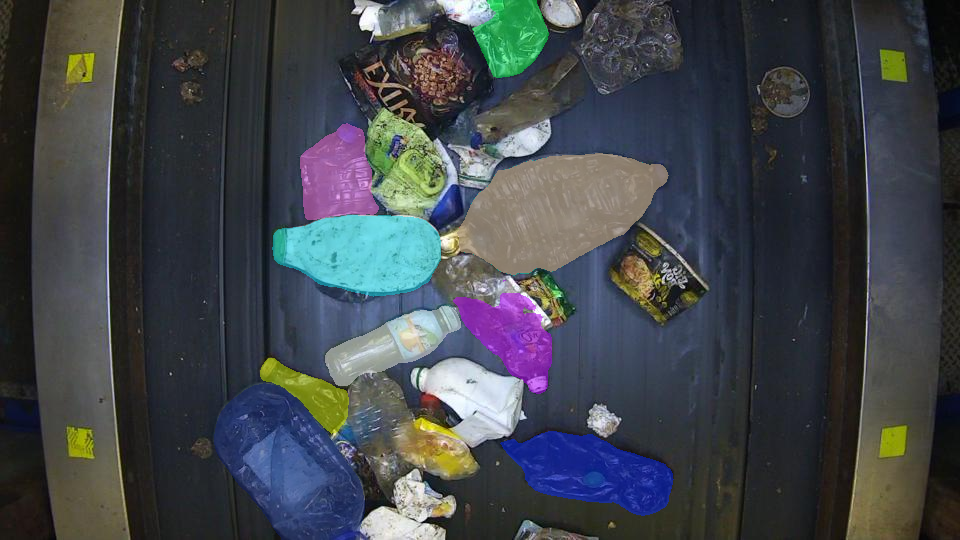

In [62]:
overrides = dict(conf=0.25, task="segment", mode="predict", model="/kaggle/input/samyolo/SAM.pt", half=True, save=True)
predictor = SAM3Predictor(overrides=overrides)

predictor.set_image(f"/kaggle/working/waste_dataSet/Warp-D/test/images/{train_cellpose[20:21][0]}")

results = predictor(bboxes=boxes) 

for r in results:
    annotated_frame = r.show(labels=False, conf=False, boxes=False)
